In [1]:
from bmtk.builder import NetworkBuilder
from bmtk.utils.sim_setup import build_env_bionet
from bmtk.builder.auxi.node_params import positions_cuboid,positions_list
import numpy as np


x = np.array([0,100])
y = np.array([0,100])
z = np.array([0,200])
pos = np.vstack([x, y, z]).T

num_of_cells = 5
postions = positions_cuboid(num_of_cells,min_dist=10)
inds = np.random.choice(np.arange(0, np.size(postions, 0)), num_of_cells, replace=False)
pos = postions[inds, :]

net = NetworkBuilder('bio_net')
net.add_nodes(N=num_of_cells, 
              pop_name='PN',
              positions=positions_list(pos),
              model_type='biophysical',
              model_template='hoc:CP_Cell',
              morphology='blank.swc')

net.add_nodes(N=num_of_cells, 
              pop_name='FSI',
              positions=positions_list(pos),
              model_type='biophysical',
              model_template='hoc:FSI_Cell',
              morphology='blank.swc')


net.save('network/')

if False:
    build_env_bionet(base_dir='./',      
                    network_dir='network/',
                    tstop=300.0, dt=0.05,
                    include_examples=False,    
                    compile_mechanisms=False,   
                    config_file='config.json',
                    overwrite_config=True
                    )

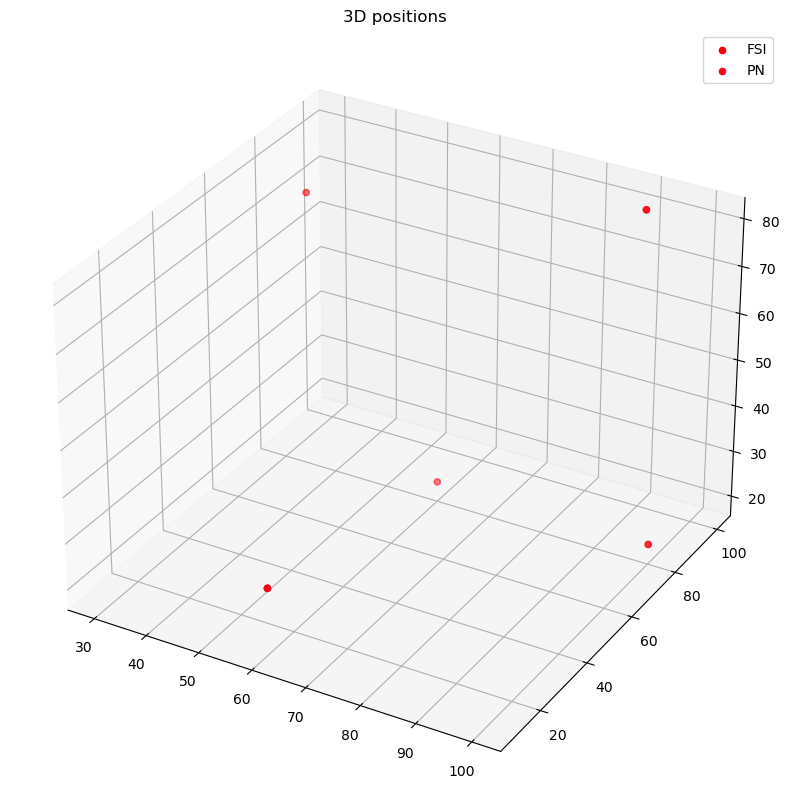

In [2]:
import bmtool.bmplot as bp
import matplotlib.pyplot as plt

bp.plot_3d_positions(config='config.json', # A BMTK config
                     populations_list='bio_net', # Network you want to plot same as sources or targets from above
                     group_by='pop_name', # node attribute same thing as sid or tid above
                     )
plt.show()

In [3]:
import os

os.system("python test_opto_run.py")
# for multiple threads mpiexec -n 2 nrniv -mpi -python test_opto_run.py but needs to be on CLI

--No graphics will be displayed.


2025-03-16 12:10:26,431 [INFO] Created log file
2025-03-16 12:10:26,504 [INFO] Building cells.
2025-03-16 12:10:26,511 [INFO] Building recurrent connections
2025-03-16 12:10:26,521 [INFO] Setting up optogenetic stimulation
2025-03-16 12:10:26,521 [INFO] Probability of infection is 1
2025-03-16 12:10:26,525 [INFO] Number of light sources is 149
2025-03-16 12:11:11,128 [INFO] Running simulation for 200.000 ms with the time step 0.050 ms
2025-03-16 12:11:11,128 [INFO] Starting timestep: 0 at t_sim: 0.000 ms
2025-03-16 12:11:11,128 [INFO] Block save every 4000 steps
2025-03-16 12:11:15,064 [INFO]     step:4000 t_sim:200.00 ms
2025-03-16 12:11:15,174 [INFO] Simulation completed in 4.047 seconds 


0

In [4]:
import h5py

def get_current_for_gid_and_probe(file_path, target_gid, probe_number):
    """
    Retrieve the current for a specific GID and probe number from the HDF5 file.
    
    Parameters:
    - file_path: Path to the HDF5 file containing the simulation data.
    - target_gid: The GID (Global ID) of the site you want to access.
    - probe_number: The probe number (index) to retrieve the current from (starting from 0).
    
    Returns:
    - A 1D array of the current at the given GID and probe across all time steps.
    """
    with h5py.File(file_path, 'r') as f:
        # Load the relevant datasets
        stim_data = f['/stim/data']  # Shape: (nsteps, total_nsites, nprobes)
        gids = f['/stim/gids']       # Shape: (total_nsites,)

        # Check if the target GID exists in the gids array
        if target_gid not in gids[:]:
            raise ValueError(f"GID {target_gid} not found in the dataset.")

        # Find the index of the target GID in the gids array
        site_idx = (gids[:] == target_gid).nonzero()[0][0]  # Find the index of the GID

        # Ensure the probe_number is valid
        if probe_number >= stim_data.shape[2]:
            raise ValueError(f"Probe number {probe_number} exceeds the number of probes ({stim_data.shape[2]})")

        # Retrieve the current for the given GID and probe number across all time steps
        current = stim_data[:, site_idx, probe_number]  # Shape: (nsteps,)

    return current


output_file = "tmp/opto_stim_currents.h5" 
temp = h5py.File(output_file)
display(temp['stim']['gids'][:])

array([0, 1, 2, 3, 4], dtype=int32)

In [5]:

cell_id1 = temp['stim']['gids'][0]
cell_id2 = temp['stim']['gids'][1]

data_for_gid0_probe0 = get_current_for_gid_and_probe(output_file, cell_id1, 0)
data_for_gid0_probe1 = get_current_for_gid_and_probe(output_file, cell_id1, 1)

data_for_gid1_probe0 = get_current_for_gid_and_probe(output_file, cell_id2, 0)
data_for_gid1_probe1 = get_current_for_gid_and_probe(output_file, cell_id2, 1)



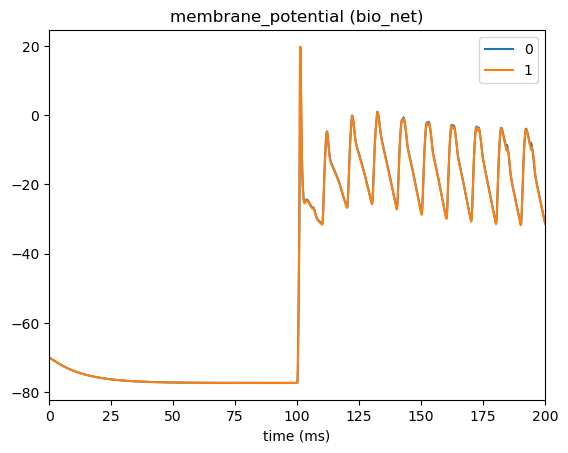

array([0, 1, 2, 3, 4], dtype=int32)

array([0, 2, 3, 4, 1])

In [7]:
from bmtk.analyzer.compartment import plot_traces
from bmtk.analyzer.spike_trains import to_dataframe

import numpy as np
import matplotlib.pyplot as plt 

_ = plot_traces(config_file='config.json', node_ids=[cell_id1,cell_id2], report_name='membrane_potential')
df = to_dataframe(config_file='config.json')
display(temp['stim']['gids'][:])
#display(len((temp['stim']['gids'][:])))
display(df['node_ids'].unique())

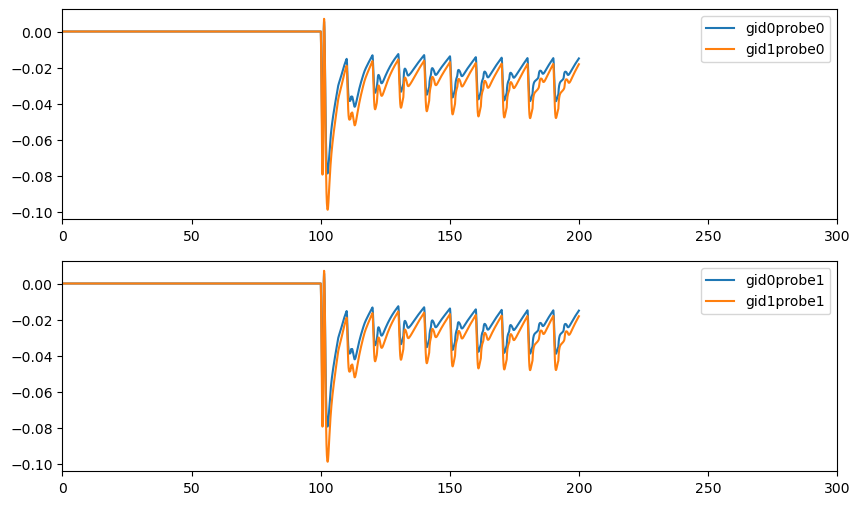

In [8]:
f = h5py.File("output/v_traces.h5")

mapping=f['report']['bio_net']['mapping']
time = np.arange(mapping['time'][0],mapping['time'][1],mapping['time'][2])

plt.figure(figsize=(10, 6))
plt.subplot(2,1,1)

plt.subplot(2, 1, 1)
plt.plot(time,data_for_gid0_probe0,label=f'gid{cell_id1}probe0')
plt.plot(time,data_for_gid1_probe0,label=f'gid{cell_id2}probe0')
plt.xlim(0,300)
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(time,data_for_gid0_probe1,label=f'gid{cell_id1}probe1')
plt.plot(time,data_for_gid1_probe1,label=f'gid{cell_id2}probe1')
plt.xlim(0,300)

plt.legend()
plt.show()